Aqui analisaremos os fatores socioeconômicos para entender se a nota do candidato de fato é afetada por eles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display_html

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
plt.ion()
plt.rcParams['figure.figsize']  = (8, 5)

In [4]:
path = 'microdados_enem2018/DADOS/'
file = 'MICRODADOS_ENEM_'

In [5]:
def display_dfs(dfs, names=[]):
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {df.head().to_html(index=False)}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

## 1. Análise exploratória

### Tratando os dados

Para a análise, utilizamos, além das informações sobre a nota do candidato, os seus dados socioeconômicos. Selecionamos, a partir do dicionário que é disponibilizado pelo INEP junto com a base de dados, aqueles atributos socioeconômicos que são relevantes no nosso contexto, eliminando as informações que não contribuem muito e/ou que são muito redundantes com outras (por exemplo, quantas máquinas de lavar tem na casa do candidato).

In [6]:
df = pd.read_csv(path+file+'2018.csv', sep=';',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'SG_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()
df['Media'] = df[['NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].sum(axis=1)/len(df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].columns)

#Alterando respostas 'Não sei' para ficarem em ordem lógica
df['Q001'] = df['Q001'].replace('H','0')
df['Q002'] = df['Q002'].replace('H','0')

#codificando atributos categóricos
encoder = preprocessing.LabelEncoder()
df['Q001'] = encoder.fit_transform(df['Q001'])
df['Q002'] = encoder.fit_transform(df['Q002'])
df['Q006'] = encoder.fit_transform(df['Q006'])
df['Q025'] = encoder.fit_transform(df['Q025'])
df['Q027'] = encoder.fit_transform(df['Q027'])
df['TP_SEXO'] = encoder.fit_transform(df['TP_SEXO'])

df.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q025,Q027,Media
8,CE,19.0,1,3,2.0,411.8,429.8,445.2,459.0,340.0,4,4,2,0,0,417.16
16,CE,18.0,1,3,2.0,478.5,513.3,564.7,514.9,580.0,3,3,1,0,0,530.28
26,PB,18.0,0,1,2.0,479.4,539.0,553.8,517.3,620.0,0,5,1,1,0,541.90
29,PI,54.0,0,3,2.0,429.8,586.7,450.3,473.3,300.0,2,1,1,0,0,448.02
39,SP,17.0,0,1,2.0,390.0,524.1,492.5,462.0,500.0,4,5,2,1,0,473.72


### Visualizações

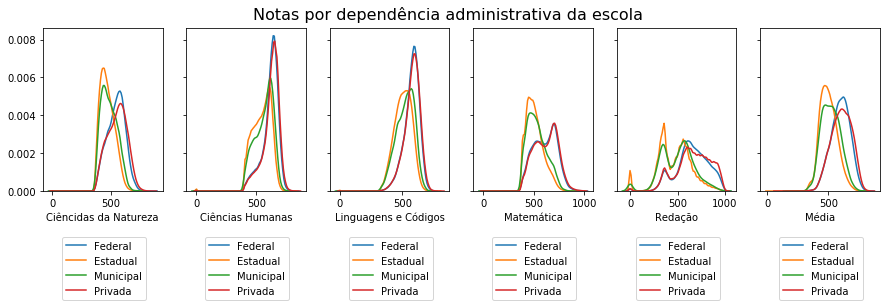

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 1][columns[i]], hist = False, label = 'Federal', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 2][columns[i]], hist = False, label = 'Estadual', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 3][columns[i]], hist = False, label = 'Municipal', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 4][columns[i]], hist = False, label = 'Privada', ax=axes[i], axlabel=labels[i])
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
fig.suptitle('Notas por dependência administrativa da escola', fontsize=16)
plt.show()

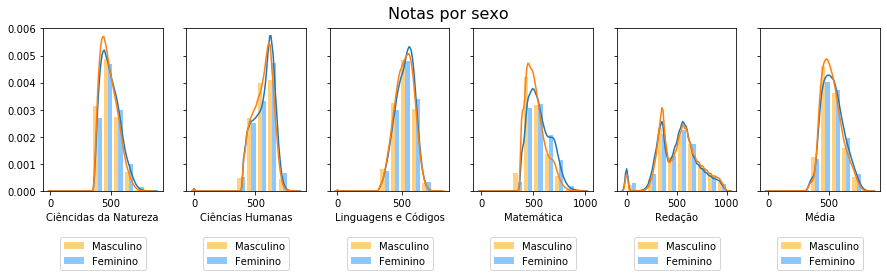

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['TP_SEXO'] == 0][columns[i]],df[df['TP_SEXO'] == 1][columns[i]]], 
                 label=['Masculino', 'Feminino'], density=True, color=['orange','dodgerblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
    
    sns.distplot(df[df['TP_SEXO'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['TP_SEXO'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Notas por sexo'), fontsize=16)
plt.show()


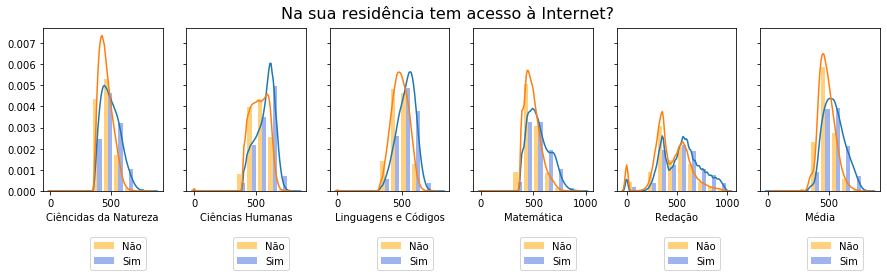

In [9]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q025'] == 0][columns[i]],df[df['Q025'] == 1][columns[i]]], 
                 label=['Não', 'Sim'], density=True, color=['orange','royalblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
        
    sns.distplot(df[df['Q025'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q025'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Na sua residência tem acesso à Internet?'), fontsize=16)
plt.show()


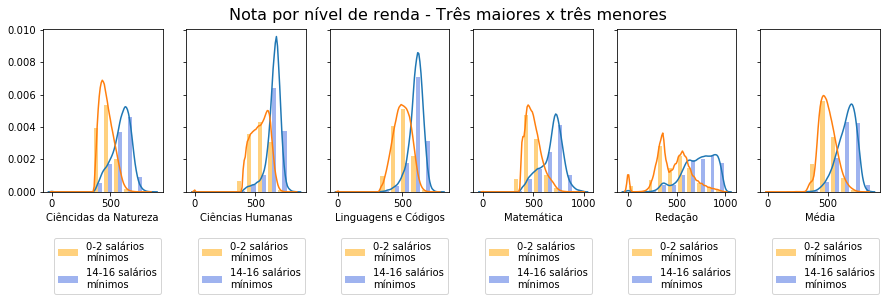

In [10]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q006'].isin([0, 1, 2])][columns[i]],df[df['Q006'].isin([14, 15, 16])][columns[i]]], 
                 label=['0-2 salários\nmínimos', '14-16 salários\nmínimos'], 
                 density=True, color=['orange','royalblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(1.03, -0.25))
    
    sns.distplot(df[df['Q006'].isin([14, 15, 16])][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q006'].isin([0, 1, 2])][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Nota por nível de renda - Três maiores x três menores'), fontsize=16)
plt.show()

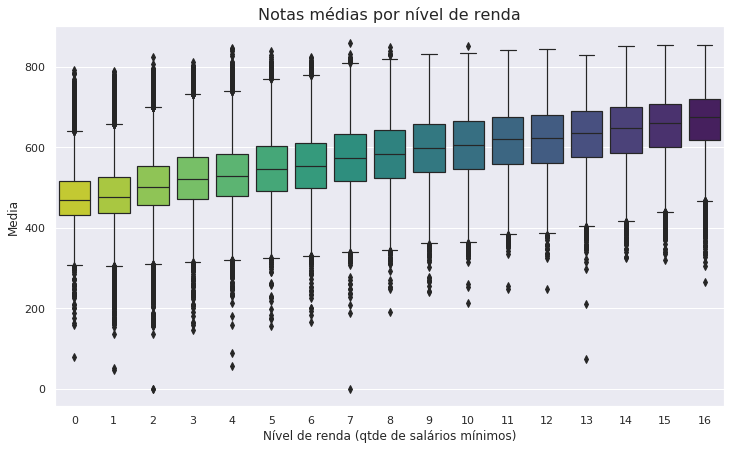

In [11]:
sns.set(style='darkgrid')
plt.figure(figsize  = [12, 7])
sns.boxplot(x = 'Q006', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por nível de renda', fontsize=16)
plt.xlabel('Nível de renda (qtde de salários mínimos)')
plt.show()

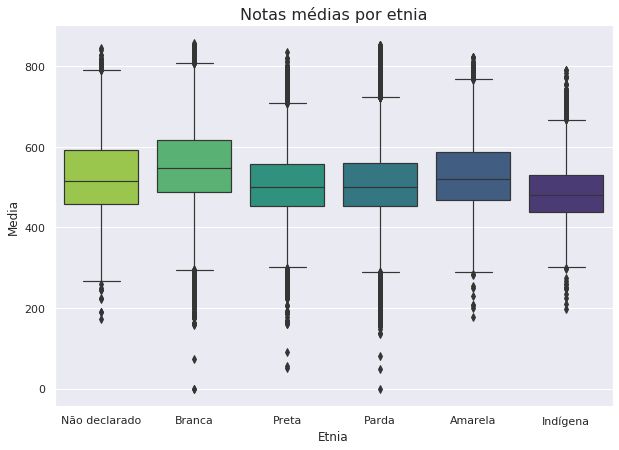

In [12]:
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'TP_COR_RACA', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por etnia', fontsize=16)
plt.xlabel('Etnia')
plt.xticks([0,1,2,3,4,5], ['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'])
plt.show()

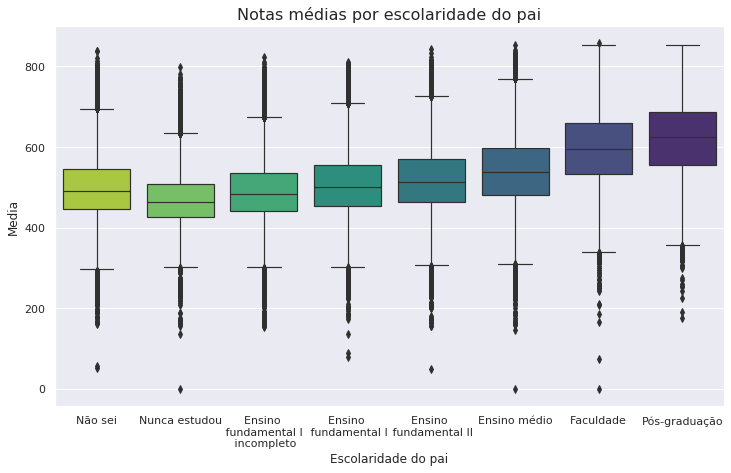

In [13]:
sns.set(style='darkgrid')
plt.figure(figsize  = [12, 7])
sns.boxplot(x = 'Q001', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por escolaridade do pai', fontsize=16)
plt.xlabel('Escolaridade do pai')
plt.xticks([0,1,2,3,4,5,6,7], ['Não sei', 'Nunca estudou', 'Ensino \n fundamental I \n incompleto', 'Ensino \n fundamental I', 'Ensino \n fundamental II', 'Ensino médio', 'Faculdade', 'Pós-graduação'])
plt.show()

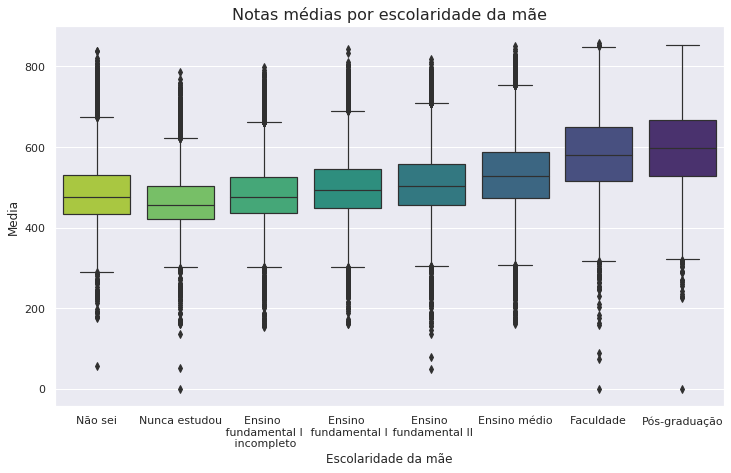

In [14]:
sns.set(style='darkgrid')
plt.figure(figsize  = [12, 7])
sns.boxplot(x = 'Q002', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por escolaridade da mãe', fontsize=16)
plt.xlabel('Escolaridade da mãe')
plt.xticks([0,1,2,3,4,5,6,7], ['Não sei', 'Nunca estudou', 'Ensino \n fundamental I \n incompleto', 'Ensino \n fundamental I', 'Ensino \n fundamental II', 'Ensino médio', 'Faculdade', 'Pós-graduação'])
plt.show()

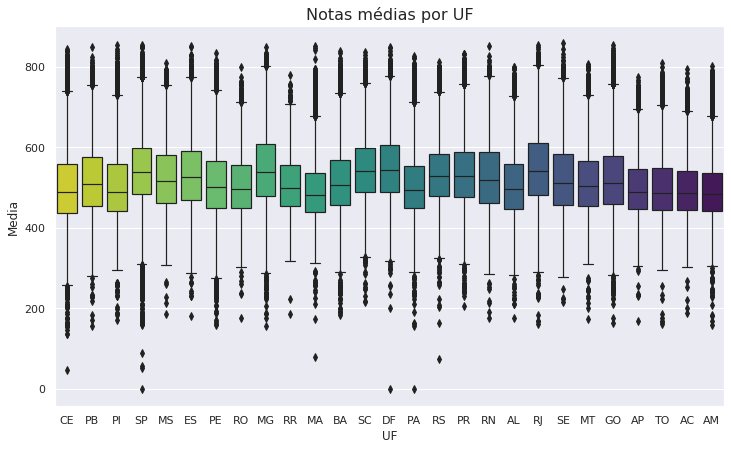

In [15]:
sns.set(style='darkgrid')
plt.figure(figsize  = [12, 7])
sns.boxplot(x = 'SG_UF_RESIDENCIA', y = 'Media', data = df, palette=("viridis_r"), linewidth=1.2)
plt.title('Notas médias por UF', fontsize=16)
plt.xlabel('UF')
plt.show()

## 2. Tentativa de regressão

Aqui tentamos fazer uma regressão linear da nota média do candidato a partir de seus atributos socioeconômicos.

### Preparando os dados

In [16]:
df = pd.read_csv(path+file+'2018.csv', sep=';',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'CO_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()

X = df.drop(columns=['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO'])
y = df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].mean(axis=1)
X.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q006,Q025,Q027
8,23,19.0,M,3,2.0,D,D,C,A,A
16,23,18.0,M,3,2.0,C,C,B,A,A
26,25,18.0,F,1,2.0,H,E,B,B,A
29,22,54.0,F,3,2.0,B,A,B,A,A
39,35,17.0,F,1,2.0,D,E,C,B,A


In [17]:
#Cast dos tipos das colunas para depois fazer onehotencoding
X[['CO_UF_RESIDENCIA','TP_COR_RACA','TP_DEPENDENCIA_ADM_ESC']] = X[['CO_UF_RESIDENCIA','TP_COR_RACA',
                                                                    'TP_DEPENDENCIA_ADM_ESC']].astype('object')
#Codificando renda para ser categórica ordinal
encoder = preprocessing.OrdinalEncoder()
X[['Q006']] = encoder.fit_transform(X[['Q006']])

#Aplicando one hot enconding às variáveis categóricas
X_enc = pd.get_dummies(X, drop_first = True)

#Add intercepto 
X_enc.insert(0,'INTERCEPTO',1)

X_enc.head()

,INTERCEPTO,NU_IDADE,Q006,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,...,Q002_D,Q002_E,Q002_F,Q002_G,Q002_H,Q025_B,Q027_B,Q027_C,Q027_D,Q027_E
8,1,19.0,2.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
16,1,18.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,1,18.0,1.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
29,1,54.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,1,17.0,2.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


### Regressão linear regularizada

In [18]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

#Normalizando variáveis numéricas
mean = X_train[['NU_IDADE']].mean()
std = X_train[['NU_IDADE']].std(ddof=1)
X_train[['NU_IDADE']] -= mean
X_train[['NU_IDADE']] /= std
X_test[['NU_IDADE']] = (X_test[['NU_IDADE']] - mean) / std

/usr/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [19]:
reg = LassoCV(fit_intercept=True, cv = 10)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print('Previsão com conjunto de teste - Regressão linear regularizada')
print('Variance score: %.2f' % reg.score(X_test, y_test))
print('MSE score: %.2f' % mean_squared_error(y_test, y_pred))

Previsão com conjunto de teste - Regressão linear regularizada
Variance score: 0.39
MSE score: 4474.68


### Regressão usando Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(n_estimators = 100, random_state = 0) 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Previsão com conjunto de teste - Random Forest')
print('Variance score: %.2f' % r2_score(y_test, y_pred_rf))
print('MSE score: %.2f' % mean_squared_error(y_test, y_pred_rf))

Previsão com conjunto de teste - Random Forest
Variance score: 0.34
MSE score: 4858.39


### Mais avaliações

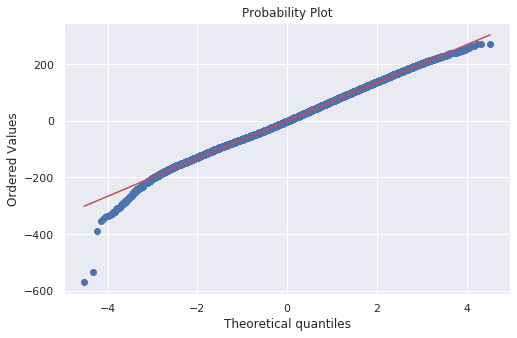

In [21]:
ss.probplot(y_test - y_pred, plot=plt)
plt.show()

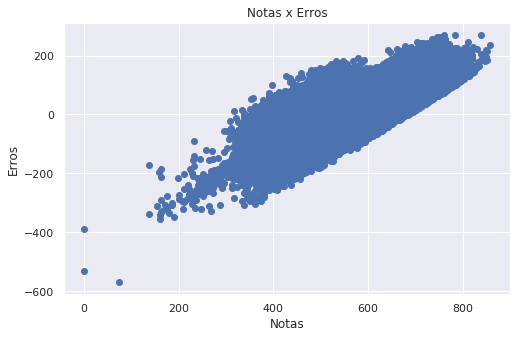

In [22]:
plt.scatter(y_test,y_test - y_pred)
plt.ylabel('Erros')
plt.xlabel('Notas')
plt.title('Notas x Erros')
plt.show()

In [23]:
print('Previsão com conjunto de treino - Regressão linear regularizada')
print('Variance score: %.2f' % reg.score(X_train, y_train))

y_t_pred_rf = rf.predict(X_train)
print('Previsão com conjunto de treino - Random Forest')
print('Variance score: %.2f' % r2_score(y_train, y_t_pred_rf))

Previsão com conjunto de treino - Regressão linear regularizada
Variance score: 0.39
Previsão com conjunto de treino - Random Forest
Variance score: 0.63


Como se pode ver no plot acima, o modelo de regressão ficou tendencioso para notas distantes da média. Além disso, o r² ruim para o próprio conjunto de treino na regressão linear regularizada evidencia que a regressão linear parece não se adequar para os dados, de forma que a relação entre os atributos socioeconômicos e a nota não é linear. Além disso, como a maioria dos atributos é categórica (exceto idade e faixa de renda), uma regressão polinomial não se adequa.

## Classificação

Diante do problema que foi exposto acima, vamos classificar as notas em três categorias, baixa, média e alta, a partir dos atributos socioeconômicos. Como temos muitas dimensões e apenas 3 classes, optamos por não utilizar o KNN (visto que é baseado em distância euclidiana), e sim uma regressão logística. Para fundamentar essa decisão, fizemos alguns testes que sustentaram o fato de que o KNN teria resultados piores.

In [24]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

um_terco = np.percentile(y,33)
dois_tercos = np.percentile(y,66)

def map_classes_estado(nota, um_terco_=um_terco, dois_tercos_=dois_tercos):
    if nota < um_terco_:
        return 'baixo'
    elif nota < dois_tercos_:
        return 'medio'
    elif nota >= dois_tercos_:
        return 'alto'

In [25]:
y_classes = y.map(map_classes_estado)

In [26]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

acc = []
f1 = []
for i in range(1000):

    #Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y_classes, test_size=0.2)

    #Normalizando variáveis numéricas
    mean = X_train[['NU_IDADE']].mean()
    std = X_train[['NU_IDADE']].std(ddof=1)
    X_train[['NU_IDADE']] -= mean
    X_train[['NU_IDADE']] /= std
    X_test[['NU_IDADE']] = (X_test[['NU_IDADE']] - mean) / std

    reg = LogisticRegressionCV(cv = 5, solver = 'newton-cg', max_iter=1000, multi_class ='multinomial')
    reg = reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    
    f1.append(f1_score(y_test, y_pred, average='weighted'))
    acc.append(accuracy_score(y_test, y_pred))
    
print(classification_report(y_test, y_pred))

/usr/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search fail

KeyboardInterrupt: 

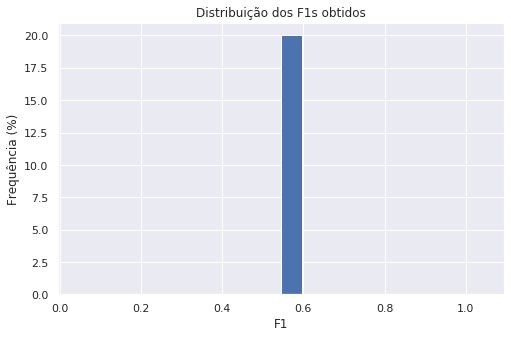

Intervalo de confiança - F1:
(0.55,0.55)


In [27]:
plt.hist(f1, bins = 20, density = True)
plt.xlabel('F1')
plt.ylabel('Frequência (%)')
plt.title('Distribuição dos F1s obtidos')
plt.show()
print('Intervalo de confiança - F1:')
print('(%.2f,%.2f)' % (np.percentile(f1,2.5), np.percentile(f1,97.5)))

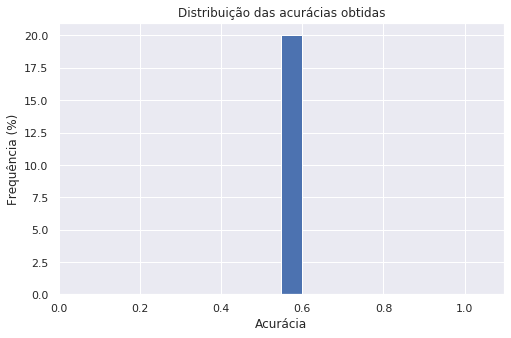

Intervalo de confiança - acurácia:
(0.55,0.55)


In [28]:
plt.hist(acc, bins = 20, density = True)
plt.xlabel('Acurácia')
plt.ylabel('Frequência (%)')
plt.title('Distribuição das acurácias obtidas')
plt.show()
print('Intervalo de confiança - acurácia:')
print('(%.2f,%.2f)' % (np.percentile(acc,2.5), np.percentile(acc,97.5)))

Como podemos observar, temos uma acurácia e um f1 razoáveis para três classes, indicando que a partir das informações socioeconômicas do indivíduo é possível fazer certa previsão do seu nível de nota e, assim, vemos que sua condição têm uma interferência mais que desejada na nota.